## VICReg

This a tensorflow implementation of VICReg - a self-supervised learning architecture that prevents collapse in an intuitive manner using a loss function that;
1. maintains the variance of each embedding over a batch above a threshold and 
2. decorrelates pairs of embeddings over a batch and attracting them to 0. 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import gc
from dataclasses import dataclass

try:
    import tensorflow_addons as tfa
except:
    !pip install tensorflow-addons
    import tensorflow_addons as tfa

try:
  import tensorflow_models as tfm
except:
  !pip install -U rich tf-models-official
  import tensorflow_models as tfm

try:
  import wandb
except:
  !pip install --upgrade -q wandb
  import wandb

from datetime import datetime
from wandb.keras import WandbCallback
import os

## Data

In vicreg, training was done using 32 Tesla GPU's. Seeing as I don't have access to that much compute, I opted to train using TPU's. When downloading the data using tensorflow_datasets, make sure to set the **try_gcs** argument to _True_. This ensures that you are using the gcs version of the data which is appropriate for utilizing the tpu. 

In [2]:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print(f"Runnning on {tpu.master()}")
except:
  print ("No TPU clusters found")

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
else:
  strategy = tf.distribute.get_strategy()

print(f"Replicas: {strategy.num_replicas_in_sync}")

Runnning on grpc://10.9.105.234:8470
Replicas: 8


In [3]:
now = datetime.now()
date = now.strftime("%Y %m %d")

In [4]:
gc.collect()
tf.keras.backend.clear_session()
tfds.disable_progress_bar()

In [5]:
train,info = tfds.load(
    "tf_flowers",
    as_supervised = True,
    with_info = True,
    split = "train",
    try_gcs = True
)

In [6]:
print(info)

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='gs://tfds-data/datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)


In [7]:
@dataclass
class C:
    BASE_LR = 0.2
    DECAY = 1e-6
    EPOCHS = 1000
    PER_REPLICA_BATCH_SIZE = 256
    GLOBAL_BATCH_SIZE = PER_REPLICA_BATCH_SIZE  * strategy.num_replicas_in_sync
    LR = GLOBAL_BATCH_SIZE/256 * BASE_LR
    PRE_TRAIN_STEPS_PER_EPOCH = int(np.ceil((3670 / GLOBAL_BATCH_SIZE)))
    TOTAL_STEPS = EPOCHS * PRE_TRAIN_STEPS_PER_EPOCH
    HEIGHT = 224
    AUTO = tf.data.experimental.AUTOTUNE
    EXPANDER_DIM = 8192
    SEED = 42
    BUFFER_SIZE = 1028
    SHAPE = [HEIGHT,HEIGHT]
    SCALE = (0.08,1.0)
    EPSILON = 1e-4
    LAMBDA = 25
    MU = 25
    NU = 1
    GAMMA = 1
    WEIGHTS_PATH = f"WEIGHTS_{date}.h5"

In [8]:
# wandb setup
wandb.login()
wandb.init(
    project="vicreg_tpu",
    config={
        "base learning_rate": C.BASE_LR,
        "global_batch_size": C.GLOBAL_BATCH_SIZE,
        "optimizer" : "custom schedule",
        "invar_coeff": C.LAMBDA,
        "var_coeff": C.MU,
        "cov_coeff": C.NU,
        "image_dim": C.HEIGHT,
        "model": "Resnet50"
    },
    group = "ResNet",
    job_type = "pretrain"
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: atiaisaac007. Use `wandb login --relogin` to force relogin


In [9]:
X = train.map(lambda x,y:x)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Augmentation Scheme

The augmentation scheme follows those of popular architectures like BYOL, barlow twins, simCLR, simsiam etc. The augmentaions used here are random resized crop, random horizontal flip with applying probability of 0.5, color jitter with probability 0.8, color drop with probability 0.2, gaussian blur with applying probability of 0.5 and solarize with a probability of 0.1

In [10]:
# Reference: https://github.com/google-research/simclr/blob/master/data_util.py
@tf.function
def _distorted_bounding_box_crop(
  image,bbox,min_object_covered=0.1,
  aspect_ratio_range=(0.75,1.33),
  area_range=(0.05,0.1),max_attempts=100
):
  shape = tf.shape(image)
  random_distorted_bbox = tf.image.sample_distorted_bounding_box(
      shape,
      bounding_boxes = bbox,
      min_object_covered = min_object_covered,
      aspect_ratio_range = aspect_ratio_range,
      area_range = area_range,
      max_attempts = max_attempts
  )
  offset,size,_ = random_distorted_bbox
  offset_y,offset_x,_ = tf.unstack(offset)
  target_y,target_x,_ = tf.unstack(size)
  image = tf.image.crop_to_bounding_box(
      image,offset_y,offset_x,target_y,target_x
  )
  return image

@tf.function    
def random_crop_resize(image,height,width,area_range=(0.08,1.0)):
  bbox = tf.constant([0.,0.,1.,1.],dtype=tf.float32,shape=[1,1,4])
  # aspect_ratio = height / width
  image = _distorted_bounding_box_crop(
      image,bbox,
      area_range=area_range               
  )
  image = tf.image.resize(image,[height,width],method="bicubic")
  return image

# Reference: https://github.com/google-research/simclr/blob/master/data_util.py
@tf.function
def gaussian_blur(image, kernel_size=23, padding='SAME'):
    sigma = tf.random.uniform((1,))* 1.9 + 0.1

    radius = tf.cast(kernel_size / 2, tf.int32)
    kernel_size = radius * 2 + 1
    x = tf.cast(tf.range(-radius, radius + 1), tf.float32)
    blur_filter = tf.exp(
        -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.cast(sigma, tf.float32), 2.0)))
    blur_filter /= tf.reduce_sum(blur_filter)
    # One vertical and one horizontal filter.
    blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
    blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
    num_channels = tf.shape(image)[-1]
    blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
    blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
    expand_batch_dim = image.shape.ndims == 3
    if expand_batch_dim:
        image = tf.expand_dims(image, axis=0)
    blurred = tf.nn.depthwise_conv2d(
        image, blur_h, strides=[1, 1, 1, 1], padding=padding)
    blurred = tf.nn.depthwise_conv2d(
        blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
    if expand_batch_dim:
        blurred = tf.squeeze(blurred, axis=0)
    return blurred

def random_apply(func,image,prob):
  return tf.cond(
      tf.math.less(
          tf.random.uniform([],0,1,tf.float32),tf.cast(prob,tf.float32)
      ),
      lambda:func(image),lambda:image
  )

# Reference: https://arxiv.org/pdf/2002.05709.pdf
@tf.function
def color_distortion(image,s=[0.4,0.4,0.2,0.1]):
  def _color_jitter(x):
      x = tf.image.random_brightness(x,max_delta = 0.8 * s[0])
      x = tf.image.random_contrast(x,
                                      lower = 1 - 0.8 * s[1],
                                      upper = 1 + 0.8 * s[1]
                                      )
      x = tf.image.random_saturation(x,
                                        lower = 1 - 0.8 * s[2],
                                        upper = 1 + 0.8 * s[2]
                                        )
      x = tf.image.random_hue(x,max_delta = 0.2 * s[3])
      x = tf.clip_by_value(x,0,255)
      return x

  def _color_drop(x):
      x = tf.image.rgb_to_grayscale(x)
      x = tf.tile(x,[1,1,3])
      return x
  
  image = random_apply(_color_jitter,image,0.8)
  image = random_apply(_color_drop,image,0.2)
  return image

@tf.function
def solarize(image,threshold = 128):
  image = tf.where(image < threshold, image, 255 - image)
  return image

@tf.function
def random_flip(image):
  image = tf.image.random_flip_left_right(image)
  return image


def augment(image):
  image = random_crop_resize(image,C.HEIGHT,C.HEIGHT,area_range=C.SCALE)
  image = random_apply(random_flip,image,0.5)
  image = color_distortion(image)
  image = random_apply(gaussian_blur,image,0.1)
  image = random_apply(solarize,image,0.2)
  image = tf.clip_by_value(image,0,255)
  return image 

In [11]:
# for training
view_1 = (
    X.shuffle(C.BUFFER_SIZE,C.SEED)
    .map(lambda x: tf.image.resize(x,C.SHAPE),num_parallel_calls=C.AUTO)
    .map(augment,num_parallel_calls=C.AUTO)
    .batch(C.GLOBAL_BATCH_SIZE)
    .prefetch(C.AUTO)
)

view_2 = (
    X.shuffle(C.BUFFER_SIZE,C.SEED)
    .map(lambda x:tf.image.resize(x,C.SHAPE),num_parallel_calls=C.AUTO)
    .map(augment,num_parallel_calls=C.AUTO)
    .batch(C.GLOBAL_BATCH_SIZE)
    .prefetch(C.AUTO)
)

fused = tf.data.Dataset.zip((view_1,view_2))

print(fused)

<ZipDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None))>



## Visualize

Visualizing the two views

In [12]:
def visualize(sample):
  plt.figure(figsize=(10, 10))
  for n in range(25):
      ax = plt.subplot(5, 5, n + 1)
      plt.imshow(sample[n].numpy().astype("int"))
      plt.axis("off")
  plt.show()

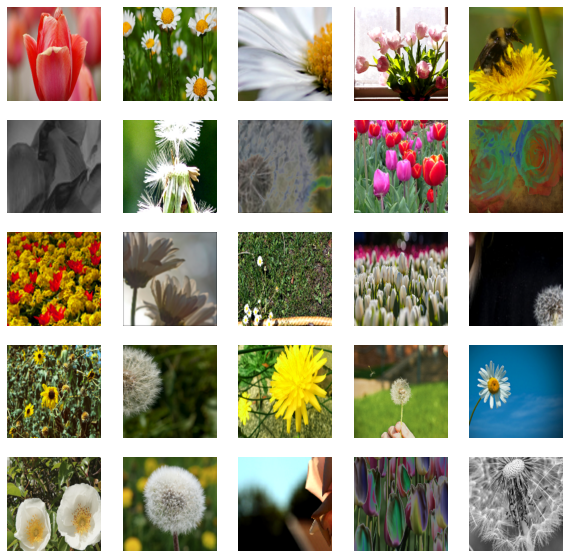

In [13]:
train_sample_one = next(iter(view_1))
visualize(train_sample_one)

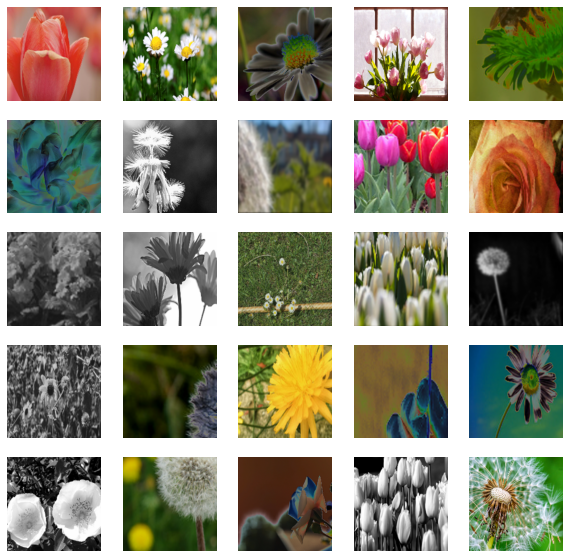

In [14]:
train_sample_two = next(iter(view_2))
visualize(train_sample_two)

## Loss Terms

As indicated in the paper, the architecture makes use of 3 loss terms to avoid a collapsing solution.


1.   Invariance loss between embeddings from the two branches
2.   Variance preservation term of each embedding over a batch applied separately to the two branches
3.   Covariance between pairs of embeddings over a batch also applied separately to the two branches.



In [15]:
def off_diagonal(x):
    n, m = x.shape[0], x.shape[1]
    assert (n == m), f"Not a square tensor, dimensions found: {n} and {m}"
    flattened_tensor = tf.reshape(x, [-1])[:-1]
    elements = tf.reshape(flattened_tensor, [n - 1, n + 1])[:, 1:]
    return tf.reshape(elements, [-1])

def invariance_loss(z_a,z_b):
  '''invariance loss'''

  mse_loss = tf.keras.metrics.mean_squared_error(z_a,z_b)
  return mse_loss

def variance_loss(z_a,z_b):
  '''variance preservation term to maintain the standard deviation 
  of each embedding over a batch applied separately to the two branches
  '''

  std_z_a = tf.math.sqrt(tf.math.reduce_variance(z_a,axis=0) + C.EPSILON)
  std_z_b = tf.math.sqrt(tf.math.reduce_variance(z_b,axis=0) + C.EPSILON)
  std_loss = (tf.math.reduce_mean(tf.keras.activations.relu(C.GAMMA - std_z_a)) +
            tf.math.reduce_mean(tf.keras.activations.relu(C.GAMMA - std_z_b))) * 0.5
  return std_loss

def covariance_loss(z_a,z_b):
  '''covariance between pairs of embedding over a batch applied 
  separately to the two branches
  '''

  z_a = z_a - tf.math.reduce_mean(z_a,axis=0)
  z_b = z_b - tf.math.reduce_mean(z_b,axis=0)
  cov_z_a = tf.linalg.matmul(z_a,z_a,transpose_a=True) / (C.GLOBAL_BATCH_SIZE-1)
  cov_z_b = tf.linalg.matmul(z_b,z_b,transpose_a=True) / (C.GLOBAL_BATCH_SIZE-1)
  cov_loss_z_a = tf.math.divide(tf.math.reduce_sum(tf.math.pow(off_diagonal(cov_z_a), 2)), C.EXPANDER_DIM)
  cov_loss_z_b = tf.math.divide(tf.math.reduce_sum(tf.math.pow(off_diagonal(cov_z_b), 2)), C.EXPANDER_DIM)
  return cov_loss_z_a + cov_loss_z_b

## Model

In this notebook, I train from scratch using ResNet18 instead of ResNet50 as indicated in the paper. Whenever I use the latter, I run into a resource exhausted error. To avoid this, I have to set the **jit_compile** argument of compile to _True_

In [16]:
class Block(tf.keras.Model):
  def __init__(self,filters,strides=1,padding="same",initializer="lecun_uniform",use_bias=False):
    super(Block,self).__init__()

    self.conv1 = tf.keras.layers.Conv2D(filters,kernel_size=3,strides=strides,
                                        padding=padding,kernel_initializer=initializer,
                                        use_bias=use_bias)
    self.sb1 = tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5)
    self.conv2 = tf.keras.layers.Conv2D(filters,kernel_size=3,strides=1,
                                        padding=padding,kernel_initializer=initializer,
                                        use_bias=use_bias)
    self.sb2 = tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5)

    if strides != 1:
      self.downsample = tf.keras.Sequential()
      self.downsample.add(tf.keras.layers.Conv2D(filters,kernel_size=1,strides=strides,
                                                 kernel_initializer=initializer,
                                        use_bias=use_bias))
      self.downsample.add(tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5))

    else:
      self.downsample = lambda x: x

  def call(self,inputs):
    residual = self.downsample(inputs)

    x = self.conv1(inputs)
    x = self.sb1(x)
    x = tf.nn.relu(x)
    x = self.conv2(x)
    x = self.sb2(x)
    x = tf.nn.relu(tf.keras.layers.add([residual,x]))
    return x


def make_block(reps,filters,strides=1):
  block = tf.keras.Sequential()
  block.add(Block(filters,strides=strides))
  for i in range(1,reps):
    block.add(Block(filters,strides=1))

  return block


class ResNet18(tf.keras.Model):
  def __init__(self):
    super(ResNet18,self).__init__()

    # Block-1
    self.conv1 = tf.keras.layers.Conv2D(
        filters=64,kernel_size=7,strides=2,use_bias = False,
        kernel_initializer = "lecun_uniform",padding="same")
    self.bn1 = tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5)
    self.act1 = tf.keras.layers.ReLU()
    self.pool = tf.keras.layers.MaxPool2D(pool_size=3,strides=2,padding="same")
    self.bn2 = tf.keras.layers.experimental.SyncBatchNormalization(epsilon=1.001e-5)

    # Identity blocks
    self.blk2 = make_block(reps=2,filters=64,strides=1)
    self.blk3 = make_block(reps=2,filters=128,strides=2)
    self.blk4 = make_block(reps=2,filters=256,strides=2)
    self.blk5 = make_block(reps=2,filters=512,strides=2)

  def call(self,inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.act1(x)
    x = self.pool(x)
    x = self.bn2(x)
    x = self.blk2(x)
    x = self.blk3(x)
    x = self.blk4(x)
    x = self.blk5(x)
    return x

  def summary(self):
    x = tf.keras.Input(shape=[*C.SHAPE,3])
    m = tf.keras.Model(inputs=x,outputs=self.call(x))
    return m.summary()

In [17]:
dummy = ResNet18()
dummy.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      9408      
                                                                 
 sync_batch_normalization (S  (None, 112, 112, 64)     256       
 yncBatchNormalization)                                          
                                                                 
 re_lu (ReLU)                (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 64)       0         
 )                                                               
                                                                 
 sync_batch_normalization_1   (None, 56, 56, 64)       256   

## Learning Rate Decay

Custom cosine decay with warmup 

In [18]:
class LR_Schedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self,learning_rate):
    self.warmup_steps = 10
    self.lr_max = learning_rate
    self.lr_start = 0
    self.lr_min = 0.002
    self.total_steps = C.TOTAL_STEPS

  @tf.function
  def __call__(self,step):
    if step < self.warmup_steps:
        lr = (self.lr_max - self.lr_start) / self.warmup_steps * step + self.lr_start
    else:
        progress = (step - self.warmup_steps) / (C.TOTAL_STEPS - self.warmup_steps)
        lr = self.lr_max * (0.5 * (1.0 + tf.math.cos(np.pi * ((1 * progress) % 1.0))))
        if self.lr_min is not None:
            lr = tf.math.maximum(self.lr_max * 0.001, float(lr))

    return lr


2000 total steps and 2 steps per epoch
Learning rate schedule: 0 to 1.6 to 0.0016


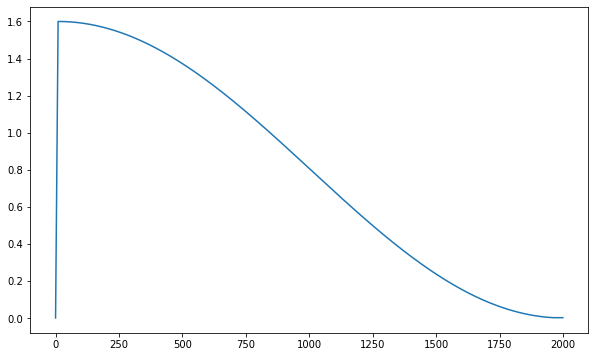

In [19]:
# visualize learning rate schedule

lrfn = LR_Schedule(C.LR)
rng = [i for i in range(C.TOTAL_STEPS)]
y = [lrfn(tf.cast(x, tf.float32)) for x in rng]

# sns.set(style='whitegrid')
fig = plt.figure(figsize=(10, 6))
plt.plot(rng, y)

print(f'{C.TOTAL_STEPS} total steps and {C.PRE_TRAIN_STEPS_PER_EPOCH} steps per epoch')
print(f'Learning rate schedule: {y[0]:.3g} to {max(y):.3g} to {y[-1]:.3g}')

## Architecture

We train a joint embedding architecture with two identical branches using a resnet backbone to produce representations. These representations are fed into a 3 layer MLP called the expander to create embeddings for applying the loss terms. 

![vicreg](https://camo.githubusercontent.com/9cffe6a81978d546ca3c54c02e634d432c1be29ace3b2560d3f4a19710aa6654/68747470733a2f2f6769746875622e636f6d2f66616365626f6f6b72657365617263682f7669637265672f626c6f622f6d61696e2f2e6769746875622f7669637265675f61726368695f66756c6c2e6a70673f7261773d74727565)

What makes vicreg different from other self-supervised learning methods is that, it;


1.   does not require the two branches to share weights, nor have identical architecture, nor the inputs be of the same nature
2.   does not require large memory banks, negative samples nor large batch sizes
3.   does not require a predictor module nor vector quantization
4.   does not require batch-wise nor feature-wise normalization



In [20]:
class VICReg(tf.keras.Model):
  def __init__(self):
    super(VICReg,self).__init__()

    self.loss_tracker = tf.keras.metrics.Mean(name="loss")
    self.mse_tracker = tf.keras.metrics.Mean(name="mse_loss")
    self.std_tracker = tf.keras.metrics.Mean(name="std_loss")
    self.cov_tracker = tf.keras.metrics.Mean(name="cov_loss")
    self.resnet18 = ResNet18()
    self.encoder = self.encoder()
    self.expander = self.expander()

  @property
  def metrics(self):
    return [
        self.loss_tracker,
        self.mse_tracker,
        self.std_tracker,
        self.cov_tracker,
        ]

  def save_weights(self):
    self.encoder.save_weights(C.WEIGHTS_PATH)

  def encoder(self):
    inputs = tf.keras.Input(shape=[*C.SHAPE,3])
    # base = tf.keras.applications.resnet50.ResNet50(
    #     weights=None,
    #     include_top = False,
    #     input_shape = [*C.SHAPE,3]
    # )

    # base.trainable = False
    # for layer in base.layers[29:]: # block 3 of resnet50
    #   layer.trainable = True
    
    x = tf.keras.layers.Rescaling(scale=1./255.)(inputs)
    # x = tf.keras.applications.resnet.preprocess_input(x)
    x = self.resnet18(x)
    o = tf.keras.layers.GlobalAveragePooling2D()(x)
    return tf.keras.Model(inputs=inputs,outputs=o,name="encoder")

  def expander(self):
    inputs = tf.keras.Input(shape=[512,])

    x = tf.keras.layers.Dense(C.EXPANDER_DIM,kernel_initializer=tf.keras.initializers.LecunUniform())(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    x = tf.keras.layers.Dense(C.EXPANDER_DIM,kernel_initializer=tf.keras.initializers.LecunUniform())(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)

    o = tf.keras.layers.Dense(C.EXPANDER_DIM,
                              use_bias = False,
                              kernel_initializer=tf.keras.initializers.LecunUniform()
                              )(x)
    return tf.keras.Model(inputs=inputs,outputs=o,name="expander")


  def train_step(self,inputs):
    x_a,x_b = inputs
    with tf.GradientTape() as tape:
      y_a,y_b = self.encoder(x_a),self.encoder(x_b)
      z_a,z_b = self.expander(y_a),self.expander(y_b)

      mse_loss = invariance_loss(z_a,z_b)
      std_loss = variance_loss(z_a,z_b)
      cov_loss = covariance_loss(z_a,z_b)

      loss = (C.LAMBDA * mse_loss + C.MU * std_loss + C.NU * cov_loss)

    total_params = self.encoder.trainable_variables + self.expander.trainable_variables
    grads = tape.gradient(loss,total_params)
    optimizer.apply_gradients(zip(grads,total_params))

    self.loss_tracker.update_state(loss)
    self.mse_tracker.update_state(mse_loss)
    self.std_tracker.update_state(std_loss)
    self.cov_tracker.update_state(cov_loss)

    return {"loss": self.loss_tracker.result(),
            "mse_loss": self.mse_tracker.result(),
            "std_loss": self.std_tracker.result(),
            "cov_loss": self.cov_tracker.result(),
            "lr": optimizer._decayed_lr(tf.float32)
            }



## Training

In [21]:
with strategy.scope():
  # schedule = tf.keras.optimizers.schedules.CosineDecay(
  #     initial_learning_rate = lrfn,
  #     decay_steps = C.TOTAL_STEPS
  # )

  optimizer = tfm.optimization.lars_optimizer.LARS(
      learning_rate = lrfn,
      weight_decay_rate = C.DECAY
  )

  model = VICReg()

# without jit_compile=True, model will run into
# a ResourceExhaustedError
model.compile(optimizer = optimizer,jit_compile=True)

h = model.fit(
    fused,
    epochs=C.EPOCHS,
    steps_per_epoch = C.PRE_TRAIN_STEPS_PER_EPOCH,
    callbacks = [WandbCallback()],
    verbose=1)


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/1000
2/2 [==============================] - 71s 1s/step - loss: 21.5429 - mse_loss: 0.0021 - std_loss: 0.9608 - cov_loss: 0.0010 - lr: 0.2667
Epoch 2/1000
2/2 [==============================] - 4s 1s/step - loss: 2773964.5000 - mse_loss: 0.0322 - std_loss: 0.8154 - cov_loss: 8257326.0000 - lr: 0.5867
Epoch 3/1000
2/2 [==============================] - 4s 980ms/step - loss: 12396346.0000 - mse_loss: 0.0934 - std_loss: 0.7272 - cov_loss: 36900680.0000 - lr: 0.9067
Epoch 4/1000
2/2 [==============================] - 4s 998ms/step - loss: 2059927.5000 - mse_loss: 0.0704 - std_loss: 0.7544 - cov_loss: 6131816.5000 - lr: 1.2267
Epoch 5/1000
2/2 [==============================] - ETA: 0s - loss: 144136.5781 - mse_loss: 0.0293 - std_loss: 0.8202 - cov_loss: 428999.3125 - lr: 1.5200

2/2 [==============================] - 4s 1s/step - loss: 144136.5781 - mse_loss: 0.0293 - std_loss: 0.8202 - cov_loss: 428999.3125 - lr: 1.5467
Epoch 6/1000
2/2 [==============================] - 4s 962ms/step - loss: 18869.0156 - mse_loss: 0.0095 - std_loss: 0.8719 - cov_loss: 56107.4141 - lr: 1.6000
Epoch 7/1000
2/2 [==============================] - 4s 962ms/step - loss: 4710.1055 - mse_loss: 0.0048 - std_loss: 0.8910 - cov_loss: 13958.9414 - lr: 1.6000
Epoch 8/1000
2/2 [==============================] - 4s 1s/step - loss: 1911.7892 - mse_loss: 0.0030 - std_loss: 0.9014 - cov_loss: 5628.4912 - lr: 1.6000
Epoch 9/1000
2/2 [==============================] - 4s 976ms/step - loss: 604.1647 - mse_loss: 0.0023 - std_loss: 0.9078 - cov_loss: 1735.7018 - lr: 1.5999
Epoch 10/1000
2/2 [==============================] - 4s 973ms/step - loss: 108.6511 - mse_loss: 0.0015 - std_loss: 0.9188 - cov_loss: 260.1485 - lr: 1.5999
Epoch 11/1000
2/2 [==============================] - 4s 979ms/step - los

In [22]:
model.save_weights()

In [23]:
from google.colab import files
files.download(C.WEIGHTS_PATH)  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>